# Support Vector Machine

In [ ]:
import os
from collections import Counter
from itertools import combinations
from itertools import combinations_with_replacement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
plt.style.use('seaborn') 

## Load data

In [ ]:
def load_data(data_path):
    data = pd.read_csv(os.path.join(data_path, 'x_train.csv'), header=None)
    target = pd.read_csv(os.path.join(data_path, 't_train.csv'), header=None)
    return data, target

DATA_DIR = '/content/drive/MyDrive/ColabNotebooks/簡仁宗 深度學習+機器學習/ML_HW3/2020/dataset'
data, target = load_data(DATA_DIR)
X, y = data.values, target.values # dataframe to array
X = X / 255. # normalize
y = y.flatten() # y 必須是1維才能用 sklearn.svm.SVC
print(X.shape, y.shape)

(300, 784) (300,)


## PCA

In [ ]:
class PCA:

    def __init__(self, n_component=2):
        self.n_component = n_component
        self.components = None
        self.mean = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0) # (n_features, 1)
        self.std = np.std(X, axis=0, ddof=0)
        X = X - self.mean
        cov = np.cov(X.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1] # [::-1] -> decreasing sort
        self.eigenvalues = eigenvalues[idxs] 
        self.eigenvectors = eigenvectors[idxs]
        self.components = eigenvectors[0:self.n_component]

    def transform(self, X):
        X = X - self.mean
        return np.real(np.dot(X, self.components.T))
    
    def reconstruction(self, Z):
        return np.real(np.dot(Z, self.components) + self.mean) # N x n_features 

In [ ]:
pca = PCA(n_component=2)
pca.fit(X)
X = pca.transform(X)
print(X.shape, y.shape)

(300, 2) (300,)


## SVM model

In [ ]:
class SVM:
    """Super Vector Machine"""

    _sparse_kernels = ["linear", "poly"]

    def __init__(self, *, kernel: str, C=1):
        # Regularization parameter
        self.C = C
        self.kernel_type = kernel

        # setting kernel function and phi
        if kernel not in self._sparse_kernels:
            raise ValueError("kernel must be 'linear' or 'poly'")
        if kernel == 'linear':
            self.phi = self.linear_phi
            self.kernel = self.dot_kernel
        elif kernel == 'poly':
            self.phi = self.polynomial_phi
            self.kernel = self.dot_kernel

        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.sample_size = X.shape[0]
        self.n_classes = np.unique(y)
        self.len_classes = len(np.unique(y))

        # combiation to expressed as one vs one 
        self.combination = list(combinations(np.arange(self.len_classes), 2))

        self.dual_coef_ = clf.dual_coef_
        self.support_ = clf.support_
        self.lagrange_coef = np.abs(clf.dual_coef_)
        self.t = self.make_target(y)
        self.support_lagrange_coef = self.get_svlm(y)

        # get parameters 
        self.weights, self.bias = self.get_parameters()
    
    def predict(self, X):
        # return np.array([self.get_classes(data) for data in X])
        return np.array([self.get_classes(data, idx) for idx, data in enumerate(X)])
    
    def get_classes(self, x, idx):
        x = self.phi(x)
        n_votes = []
        for c in self.combination:
            weights = self.weights[c]
            bias = self.bias[c]
            coef_t = self.support_lagrange_coef[c]*self.t[c]
            y = np.sign(np.dot(weights, x.T) + bias)
            if y == 1:
                n_votes.append(c[0])
            else:
                n_votes.append(c[1])
        return Counter(n_votes).most_common()[0][0]

    def make_target(self, y):
        """make a array target 1 for class 1, -1 for class 2 and the others
        class is 0
        """
        # make target dictionary 
        t = {}
        for c in self.combination:
            t[c] = np.zeros(self.sample_size)
            # get 1 and -1 index 
            # and make 1 for class c[0] 2 for class c[1]
            one_idx = np.where(y==c[0])
            negetive_one_idx = np.where(y==c[1])
            t[c][one_idx] = np.ones(len(one_idx))
            t[c][negetive_one_idx] = np.full(len(negetive_one_idx), -1)
        return t
    
    def get_svlm(self, y):
        """get support vectors lagrange multiplier"""
        a = np.zeros((self.sample_size, self.len_classes-1))
        a[self.support_] = self.lagrange_coef.T

        coef_indices = list(combinations_with_replacement(np.arange(self.len_classes-1), 2))
        # make lagrange multiplier dictionary 
        lagrange_coef = {}
        for c, coef_idx in zip(self.combination, coef_indices):
            lagrange_coef[c] = np.zeros(self.sample_size)
            idx_0 = np.where(y==c[0]) # idx for class c[0]
            idx_1 = np.where(y==c[1]) # idx for class c[1]
            lagrange_coef[c][idx_0] = a[idx_0, coef_idx[1]]
            lagrange_coef[c][idx_1] = a[idx_1, coef_idx[0]]
        return lagrange_coef
 
    def get_parameters(self, threshold=1e-5):
        # inputs to kernel features
        X = self.phi(self.X)

        weights = {}
        bias = {}
        for c in self.combination:
            coef = self.support_lagrange_coef[c]
            coef_t = self.support_lagrange_coef[c]*self.t[c]
            t = self.t[c]
            # find weights
            weights[c] = np.dot(coef_t, X)

            # find bias
            m_idx = np.where((coef > threshold) & (coef < self.C))[0]
            s_idx = np.nonzero(coef)[0]
            bias[c] = np.mean(t[m_idx] - np.dot(coef_t[s_idx], self.kernel(X[m_idx], X[s_idx]).T))
        return weights, bias

    def linear_phi(self, X):
        return X

    def polynomial_phi(self, X):
        """X array-like or 1-dim"""
        if len(X.shape) == 1:
            x1, x2 = X[0], X[1]
            return np.array([x1**2, np.sqrt(2)*x1*x2, x2**2])
        if len(X.shape) == 2:
            x1, x2 = np.expand_dims(X[:, 0], 1), np.expand_dims(X[:, 1], 1)
            return np.concatenate((x1**2, np.sqrt(2)*x1*x2, x2**2), axis=1)
    
    def dot_kernel(self, x, xn):
        return np.dot(x, xn.T)

## Plot decision regions and support vector

In [ ]:
color_list = ['tab:blue', 'tab:red', 'tab:green']
color_ticks = np.arange(-1, 3)

def plot_DicisionRegions(model, X, y, num=500, extend=1):
    
    x1 = np.linspace(np.min(X[:,0])-extend, np.max(X[:,0])+extend, num=num)
    x2 = np.linspace(np.min(X[:,1])-extend, np.max(X[:,1])+extend, num=num)
    x1, x2 = np.meshgrid(x1, x2)
    xy = np.c_[x1.flatten(), x2.flatten()]
    z = model.predict(xy).reshape(x1.shape)

    plt.figure(figsize=(8,6))
    
    # plot contourf
    plt.contourf(x1, x2, z, levels=color_ticks, colors=color_list, alpha=0.5)

    # scarrter plot for each class
    n_classes = np.unique(y)
    for c in n_classes:
        c_idx = np.where(y==c)[0]
        X_c = X[c_idx]
        plt.scatter(X_c[:,0], X_c[:,1], c=color_list[c], marker='x', label=f'Tibetan {str(c)}')
    # plot support vectors
    x_sv, y_sv = X[model.support_, 0], X[model.support_, 1]
    plt.scatter(x_sv, y_sv, facecolors='None', edgecolors='k', linewidths=1, label="Support Vector")
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title(f'{model.kernel_type} kernel')
    plt.show()

## 2-1 Difference between two decision approaches

Analyze the difference between two decision approaches (one-versus-the-rest and one- versus-one). 

Decide which one you want to use and explain why you choose this approach.

Ans:


*   **one-versus-the-rest**

> 相當於”K 個函數找最大”，然後決定分類。 也就是 K 類別就有 K 個分類器，其中第 K 個 model 的預測值在訓練時，會把來自第 K 類的樣本視為”1”，其餘 K-1 類視為”0”，之後根據 這個方法找出 input x 最可能從哪一個類別出來。

*  **one- versus-one**

> 透過”投票”來決定分類。 一次比較一組二元分類器，共有 K(K-1)/2 個分類器，最後 input x 被分到據有最高票的那個類別。 我在這一題所選擇的是:「One-versus-on」。

**我這一題所選擇的是:「One-versus-on」。**







## 2-2 Linear kernel

Use the dataset to build a SVM with linear kernel to do multi-class classification. 

Then plot the corresponding decision boundary and support vectors.

hyper-parameter **C = 0.1**

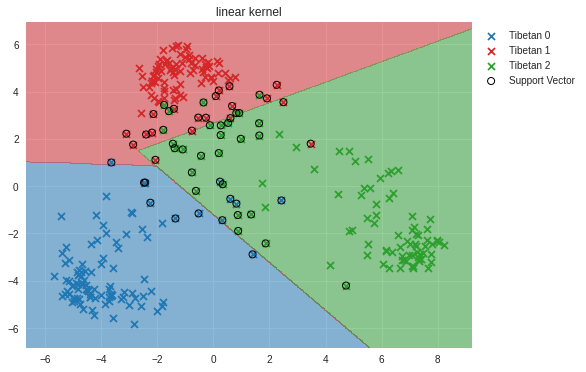

In [ ]:
clf = svm.SVC(kernel='linear', C=0.1, decision_function_shape='ovo')
clf.fit(X, y)
model = SVM(kernel='linear', C=0.1)
model.fit(X, y)
plot_DicisionRegions(model, X, y)

## 2-3 Polynomial kernel

Repeat (2) with polynomial kernel (degree = 2).

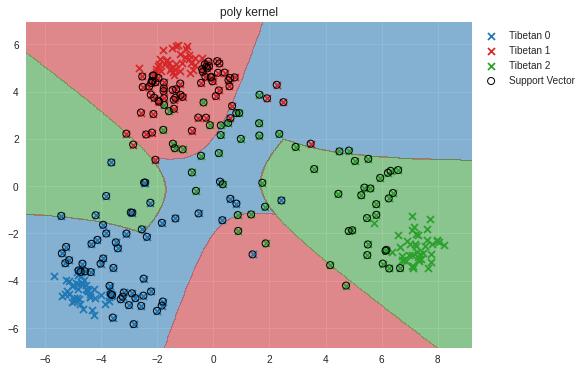

In [ ]:
clf = svm.SVC(kernel='poly', C=0.1, degree=2, decision_function_shape='ovo')
clf.fit(X, y)
model = SVM(kernel='poly', C=0.1)
model.fit(X, y)
plot_DicisionRegions(model, X, y)